---
format:
  html:
    toc: true
    embed-resources: true
    code-fold: false
execute:
  echo: true
---

* REVISED-Business Goals
 
   Following the exploratory task of identifying the top 10 creators, we move on to assess the sentiment of top creators' comments to gauge the overall emotional tone of their response. This will provide further and more scientific insights into the influencer-audience interactions in MakeupAddiction.

  
* Technical Proposal

    Utilize NLP libraries like NLTK, and preprocess the text data, including tokenization, removing stop words, and lemmatization for word frequency analysis. Apply sentiment analysis to the preprocessed comments to determine their emotional tone. Calculate sentiment scores for each comment to quantify the intensity of emotions. Aggregate the sentiment scores of comments from each influencer. Visualize the sentiment analysis results using charts to provide a clear understanding of influencers' emotional impact. 
    
We have refined our business goal after a thorough examination of the data, as we encountered challenges linking comments to their respective submissions. Despite attempts to use inner joins such as submission.id == comments.link_id and submission.id == comments.parent_id, we were unable to establish the necessary connections.

In light of these challenges in investigating user comments directed at influencers, we have pivoted our focus to analyzing influencers' responses to their audience. This approach allows us to explore the dynamic interactions and reactions between influencers and their audience, providing valuable insights into the engagement dynamics within our platform.







In [5]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
# install Python Reddit API Wrapper for getting external data Karma
%pip install pyspark==3.4.0
# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [6]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd

import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import CountVectorizer, StopWordsRemover,Tokenizer
from pyspark.ml import Pipeline

import plotly.graph_objects as go

from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import numpy as np

from nltk.stem import WordNetLemmatizer
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [4]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.driver.memory","16G")
    .config("spark.driver.maxResultSize", "0") 
    .config("spark.kryoserializer.buffer.max", "2000M")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b6797c96-cfd7-4138-9d7b-b4ecedfb5486;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-861795727138/project/comments/yyyy=*


23/12/07 06:24:26 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,053,280x21
CPU times: user 3.17 s, sys: 232 ms, total: 3.4 s
Wall time: 5min 52s


## Sentiment Analysis

In [8]:
# Build the sentiment analysis pipeline
MODEL_NAME='sentimentdl_use_twitter'

documentAssembler = DocumentAssembler()\
    .setInputCol("cleaned_text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ \ ]

2023-12-07 06:47:27.153084: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ / ]

2023-12-07 06:47:32.002838: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2023-12-07 06:47:32.075094: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2023-12-07 06:47:32.149430: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2023-12-07 06:47:32.199287: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2023-12-07 06:47:32.411785: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.


[ — ]

[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
Download done! Loading the resource.
[OK!]


In [19]:
# Read data from EDA-Find top10 Creators in MakeupAddiction and list their names
topcreators= pd.read_csv('../../data/csv/top10creator.csv')

topcreators= topcreators['author'].tolist()
topcreators = list(set(topcreators))

# Define a function to clean the text
def clean_text(data):
    cleaned_data = F.regexp_replace(data, '[^a-zA-Z0-9\s]', '')
    cleaned_data = F.lower(cleaned_data)
    cleaned_data = F.trim(cleaned_data)
    return cleaned_data

# Filter 10 top creators who comment most 
cmt_author= comments.select('author','body').filter(F.col('author').isin(topcreators))
cmt_author.cache()
top10_names = cmt_author.groupBy('author').count().orderBy(F.desc('count')).limit(10).select('author').rdd.flatMap(lambda x: x).collect()
cmt_author= cmt_author.select('author','body').filter(F.col('author').isin(top10_names))

# Setup for sentiment analysis, organize the results
cmt_author = cmt_author.withColumn("cleaned_text", clean_text(F.col("body")))
pipelineModel = nlpPipeline.fit(cmt_author)
stmt_result = pipelineModel.transform(cmt_author)
stmt_result = stmt_result.withColumn('sentiment',F.explode(stmt_result.sentiment.result))
stmt_result = stmt_result.select('author','body','cleaned_text','sentiment')

23/12/07 08:39:18 WARN CacheManager: Asked to cache already cached data.


In [31]:
# Groupby and count 
top10creator_stmt_analysis= stmt_result.groupby('author','sentiment').count()
summary = top10creator_stmt_analysis.groupBy('author').pivot('sentiment').agg(F.first('count'))
summary.show()

+------------------+--------+-------+--------+
|            author|negative|neutral|positive|
+------------------+--------+-------+--------+
|   sadperson123456|      57|     12|     684|
|         ahbagelxo|     121|     52|    1401|
|waterfromthevalley|      13|      6|     990|
|            zemele|     151|     42|     910|
|  Sick-Sad-World32|      85|     22|     570|
|     DisheveledBoy|      79|     17|     610|
|     cuziluvmakeup|      43|     12|     776|
|      Ralucamakeup|      36|     16|     541|
|          Veeeeezy|      44|      9|     486|
|     Dominorepulsa|      94|     68|     874|
+------------------+--------+-------+--------+



## Visualizaion

In [25]:
# save the analytical results 
top10creator_stmt_analysis.to_csv('../../data/csv/top10creator_cmt_stmt_results.csv',index=False)

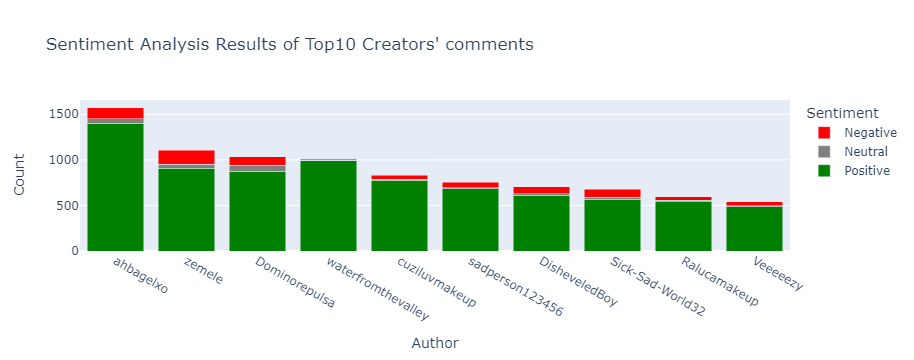

In [18]:
# Plot figure
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd

# Read from data and sort
top10creator_stmt_analysis= pd.read_csv('../../data/csv/top10creator_cmt_stmt_results.csv')
top10creator_stmt_analysis['total_length'] = top10creator_stmt_analysis.groupby('author')['count'].transform('sum')
top10creator_stmt_analysis = top10creator_stmt_analysis.sort_values(by='total_length', ascending=False)


fig = go.Figure()

colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

for sentiment, color in colors.items():
    subset = top10creator_stmt_analysis[top10creator_stmt_analysis['sentiment'] == sentiment]
    fig.add_trace(go.Bar(
        x=subset['author'],
        y=subset['count'],
        name=sentiment.title(), 
        marker_color=color))

fig.update_layout(
    title="Sentiment Analysis Results of Top10 Creators' comments",
    xaxis_title='Author',
    yaxis_title='Count',
    barmode='stack',
    legend=dict(title='Sentiment'),
    hovermode='x')

fig.write_html('../../data/plots/top10creators_stmt_results.html')

fig.show()

The sentiment analysis of the provided authors reveals distinctive communication styles. Notably, "sadperson123456," "ahbagelxo," and "waterfromthevalley" consistently exhibit an optimistic tone, with a significant abundance of positive sentiments in their content. This suggests a generally positive and upbeat approach in their communication. On the contrary, "zemele" stands out for a more critical or negative expression, as evidenced by the higher count of negative sentiments.

Authors such as "Sick-Sad-World32" and "DisheveledBoy" present a more balanced mix of sentiments, showcasing a nuanced and diverse communication style. The prevalence of both positive and negative expressions suggests a range of topics and perspectives covered in their content. Meanwhile, authors like "cuziluvmakeup," "Veeeeezy," and "Dominorepulsa" exhibit a clear positive dominance, suggesting an overall optimistic or favorable communication style.

The analysis provides insights into how each influencer communicates with their audience. Understanding the sentiments of influencer responses provides a glimpse into how these figures interact with their followers and manage feedback. Positive interactions may strengthen this relationship, while negative or neutral responses may impact how followers perceive an influencer